## Preparation

### Loading packages, setting up gpu, loading models

In [1]:
# required packages
from transformers import AutoProcessor, CLIPTextModel, CLIPVisionModel, PreTrainedModel
import torch
import torch_directml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import glob
import time
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from scipy.stats import pearsonr as corr
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from nilearn import datasets
from nilearn import plotting
from typing import List, Dict

c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setup cuda device
AMD = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if AMD:
    device = torch_directml.device()

In [3]:
global vis_model
vis_model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
vis_model.eval()

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.7.self_attn.out_proj.weight', 'text_model.encoder.layers.10.layer_norm2.weight', 'text_model.encoder.layers.0.layer_norm1.bias', 'text_model.encoder.layers.10.self_attn.out_proj.weight', 'text_model.encoder.layers.0.self_attn.k_proj.bias', 'text_model.embeddings.position_ids', 'text_model.encoder.layers.4.layer_norm2.bias', 'text_model.encoder.layers.6.self_attn.out_proj.weight', 'text_model.encoder.layers.2.layer_norm2.bias', 'text_model.encoder.layers.1.mlp.fc1.weight', 'text_model.embeddings.position_embedding.weight', 'text_model.encoder.layers.3.self_attn.v_proj.bias', 'text_model.encoder.layers.3.self_attn.k_proj.bias', 'text_model.encoder.layers.2.mlp.fc1.weight', 'text_model.encoder.layers.3.self_attn.q_proj.weight', 'text_model.encoder.layers.5.mlp.fc2.bias', 'text_model.encoder.layers.3.layer_norm1.bias', 'text_model.encoder.layers.

CLIPVisionModel(
  (vision_model): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (position_embedding): Embedding(50, 768)
    )
    (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2

In [4]:
global txt_model
txt_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
txt_model.eval()

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.8.self_attn.q_proj.weight', 'vision_model.encoder.layers.1.self_attn.q_proj.bias', 'vision_model.encoder.layers.6.layer_norm1.weight', 'vision_model.encoder.layers.8.self_attn.v_proj.bias', 'vision_model.encoder.layers.2.self_attn.out_proj.weight', 'vision_model.post_layernorm.weight', 'vision_model.encoder.layers.9.mlp.fc1.weight', 'vision_model.encoder.layers.5.mlp.fc1.bias', 'vision_model.encoder.layers.9.self_attn.q_proj.bias', 'vision_model.encoder.layers.3.self_attn.k_proj.weight', 'vision_model.encoder.layers.0.mlp.fc2.bias', 'vision_model.encoder.layers.3.mlp.fc1.weight', 'vision_model.encoder.layers.11.layer_norm2.weight', 'vision_model.encoder.layers.1.mlp.fc1.weight', 'vision_model.encoder.layers.5.mlp.fc1.weight', 'vision_model.encoder.layers.4.layer_norm2.weight', 'vision_model.encoder.layers.2.self_attn.k_proj.weight', 'vision_m

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05, ele

In [5]:
# Defining Models
global processor
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

### Defining Classes

#### ImageDataset & TextDataset

The ImageDataset and TextDataset classes are used to create datasets for torch dataloaders.
The ImageDataset is used for the images and the TextDataset for the captions of the coco images.

In [6]:
# Dataset Classes for Batching
class ImageDataset(Dataset):
    def __init__(self, image_list, processor):
        self.image_list = image_list
        self.processor = processor

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image = Image.open(self.image_list[idx])
        image = self.processor(images=image, return_tensors="pt", padding=True)
        return image["pixel_values"].squeeze()

class TextDataset(Dataset):
    def __init__(self, text, max_length, processor):
        self.text = processor(text=text, return_tensors="pt", padding="max_length", max_length=max_length)

    def __len__(self):
        return len(self.text["input_ids"])

    def __getitem__(self, idx):
        return self.text["input_ids"][idx]

#### Subject Class

The Subject class is initialized with a valid subject id (e.g., "subj01"). It stores all relevant paths and can load the data for the given subject.

In [7]:
class Subject:
    """Class to access all relevant data for a given subject"""
    def __init__(self, subject="subj01"):
        assert subject in ["subj01", "subj02", "subj03", "subj04", "subj05", "subj06", "subj07", "subj08",], "Invalid subject"
        self.subject = subject
        self.data_dir = "data/algonauts_2023_challenge_data"
        self.training_images_dir = f"{self.data_dir}/{subject}/training_split/training_images"
        self.test_images_dir = f"{self.data_dir}/{subject}/test_split/test_images"
        self.training_fmri_dir = f"{self.data_dir}/{subject}/training_split/training_fmri"
        self.roi_masks_dir = f"{self.data_dir}/{subject}/roi_masks"
        self.submission_dir = f"algonauts_2023_challenge_submission"
        # Load these as needed
        self.train_img_list = None
        self.test_img_list = None
        self.train_cap_list = None
        self.test_cap_list = None
        self.lh_fmri = None
        self.rh_fmri = None
        self.lh_roi_masks = None
        self.rh_roi_masks = None
        self.roi_name_maps = None
        self.lh_challenge_rois = None
        self.rh_challenge_rois = None
        self.train_img_dataloader = None
        self.test_img_dataloader = None
        self.train_cap_dataloader = None
        self.test_cap_dataloader = None            
        
    def load_image_paths(self) -> None:
        """Loads the image paths from the training and test directories"""
        self.train_img_list = glob.glob(f"{self.training_images_dir}/*.png")
        self.train_img_list.sort()
        self.test_img_list = glob.glob(f"{self.test_images_dir}/*.png")
        self.test_img_list.sort()
        print(f"Training images: {len(self.train_img_list)}")
        print(f"Test images: {len(self.test_img_list)}")

    def load_captions(self) -> None:
        """Loads and matches the captions from the csv file"""
        if self.train_img_list is None:
            self.load_image_paths()
        train_cap_file = pd.read_csv(f'{self.data_dir}/algonauts_2023_caption_data.csv')
        img_match = [int(i[-9:-4]) for i in self.train_img_list]
        self.train_cap_list = train_cap_file[(train_cap_file['subject'] == self.subject) & (train_cap_file['nsdId'].isin(img_match))]['caption'].tolist()
        self.test_cap_list = train_cap_file[(train_cap_file['subject'] == self.subject) & (~train_cap_file['nsdId'].isin(img_match))]['caption'].tolist()
        print(f"Training captions: {len(self.train_cap_list)}")
        print(f"Test captions: {len(self.test_cap_list)}")
    
    def load_neural_data(self) -> None:
        """Loads the neural data from the .npy files"""
        self.lh_fmri = np.load(f"{self.training_fmri_dir}/lh_training_fmri.npy")
        self.rh_fmri = np.load(f"{self.training_fmri_dir}/rh_training_fmri.npy")
        print(f"Left hemisphere neural data loaded. Shape: {self.lh_fmri.shape}")
        print(f"Right hemisphere neural data loaded. Shape: {self.rh_fmri.shape}")

    def create_dataloaders(self, processor, batch_size) -> None:
        """Creates the dataloaders for the images and captions"""
        if self.train_img_list is None:
            self.load_image_paths()
        if self.train_cap_list is None:
            self.load_captions()
        max_caption_len = processor(text=self.train_cap_list + self.test_cap_list, return_tensors="pt", padding=True)["input_ids"].shape[1]   
        train_txt_dataset = TextDataset(self.train_cap_list, max_caption_len, processor)
        test_txt_dataset = TextDataset(self.test_cap_list, max_caption_len, processor)
        train_img_dataset = ImageDataset(self.train_img_list, processor)
        test_img_dataset = ImageDataset(self.test_img_list, processor)
        self.train_img_dataloader = DataLoader(train_img_dataset, batch_size=batch_size, shuffle=False)
        self.test_img_dataloader = DataLoader(test_img_dataset, batch_size=batch_size, shuffle=False)
        self.train_txt_dataloader = DataLoader(train_txt_dataset, batch_size=batch_size, shuffle=False)
        self.test_txt_dataloader = DataLoader(test_txt_dataset, batch_size=batch_size, shuffle=False)
        print(f"Train image dataloader: {len(self.train_img_dataloader)} batches")
        print(f"Test image dataloader: {len(self.test_img_dataloader)} batches")
        print(f"Train caption dataloader: {len(self.train_txt_dataloader)} batches")
        print(f"Test caption dataloader: {len(self.test_txt_dataloader)} batches")

    def load_challenge_rois(self) -> None:
        """Loads the challenge rois from the .npy files"""
        # Load the ROI classes mapping dictionaries
        roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
            'mapping_floc-faces.npy', 'mapping_floc-places.npy',
            'mapping_floc-words.npy', 'mapping_streams.npy']
        self.roi_name_maps = []
        for r in roi_mapping_files:
            self.roi_name_maps.append(np.load(f"{self.roi_masks_dir}/{r}", allow_pickle=True).item())

        # Load the ROI brain surface maps
        lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
            'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
            'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
            'lh.streams_challenge_space.npy']
        rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
            'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
            'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
            'rh.streams_challenge_space.npy']
        self.lh_challenge_rois = []
        self.rh_challenge_rois = []
        for r in range(len(lh_challenge_roi_files)):
            self.lh_challenge_rois.append(np.load(f"{self.roi_masks_dir}/{lh_challenge_roi_files[r]}"))
            self.rh_challenge_rois.append(np.load(f"{self.roi_masks_dir}/{rh_challenge_roi_files[r]}"))

    def load_roi_masks(self, roi="V1v", hemisphere="lh"):
        valid_roi = ["V1v", "V1d", "V2v", "V2d", "V3v", 
                     "V3d", "hV4", "EBA", "FBA-1", "FBA-2", 
                     "mTL-bodies", "OFA", "FFA-1", "FFA-2", 
                     "mTL-faces", "aTL-faces", "OPA", "PPA", 
                     "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", 
                     "mTL-words", "early", "midventral", "midlateral", 
                     "midparietal", "ventral", "lateral", "parietal",
                     "all-vertices"]
        valid_hemisphere = ["lh", "rh"]
        assert roi in valid_roi, "Invalid ROI"
        assert hemisphere in valid_hemisphere, "Invalid hemisphere"

        # Define the ROI class based on the selected ROI
        if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
            roi_class = 'prf-visualrois'
        elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
            roi_class = 'floc-bodies'
        elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
            roi_class = 'floc-faces'
        elif roi in ["OPA", "PPA", "RSC"]:
            roi_class = 'floc-places'
        elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
            roi_class = 'floc-words'
        elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
            roi_class = 'streams'
        else:
            roi_class = roi
        roi_class_dir = f"{hemisphere}.{roi_class}_fsaverage_space.npy"
        roi_map_dir = f"mapping_{roi_class}.npy"
        fsaverage_roi_class = np.load(f"{self.roi_masks_dir}/{roi_class_dir}")
        roi_map = None
        if roi != "all-vertices":
            roi_map = np.load(f"{self.roi_masks_dir}/{roi_map_dir}", allow_pickle=True).item()
        return fsaverage_roi_class, roi_map

#### CLIPFeatureExtractor Class

The CLIPFeatureExtractor class is used to extract the hidden states from a clip model.

In [8]:
class CLIPFeatureExtractor():
    """Extracts the features from hidden states of a CLIP model."""
    def __init__(
            self, 
            idxs: list = [i for i in range(13)], # hidden layer indices to extract features from. Standard CLIP has an embedding layer and 12 transformer layers.
            last_hidden_layer: bool = False, # whether to extract features from the last hidden layer
            model: PreTrainedModel = None, # CLIP model
            dataloader: DataLoader = None, # dataloader for batching
            ) -> None:
        self.idxs = idxs
        self.last_hidden_layer = last_hidden_layer
        self.generate_feature_dict()
        if self.last_hidden_layer:
            self.idxs.append(13) # adds an additional idx to allow for loop zip()
        self.model = model
        self.dataloader = dataloader
    
    def generate_feature_dict(self) -> None:
        """Generates a feature dict according to the idxs and last_hidden_layer attributes."""
        feature_dict = {}
        for idx in self.idxs:
            if idx == 0:
                feature_dict["Embedding Layer"] = None
            else:
                feature_dict[f"Transformer Layer {idx}"] = None
        if self.last_hidden_layer:
            feature_dict["Final Layer"] = None
        self.feature_dict = feature_dict
    
    def concat_features(self, features: dict) -> None:
        """Adds extracted features to the feature dict.
        Args:
            features: features extracted from the output of a CLIP model"""
        keys = list(self.feature_dict.keys())
        # check if feature_dict is empty
        if self.feature_dict[keys[0]] is None:
            self.feature_dict = features
        else:
            for key in keys:
                self.feature_dict[key] = np.concatenate((self.feature_dict[key], features[key]), axis=0)

    def extract_raw_features(self, output) -> None: 
        """Extracts features from the hidden states of a CLIP model and concates them to the feature_dict.
        Args:
            output: output of a CLIP model
        """
        features = {}
        for idx, key in zip(self.idxs, self.feature_dict.keys()):
            if key == "Final Layer":
                features[key] = output.last_hidden_state.cpu().detach().numpy()
            else:
                features[key] = output.hidden_states[idx].cpu().detach().numpy()
        self.concat_features(features)
    
    def extract_raw_features_from_model(self) -> None:
        """Runs the CLIP model on the dataloader and extracts features from the hidden states."""
        self.model = self.model.to(device)
        with torch.no_grad():
            for batch in tqdm(self.dataloader):
                batch = batch.to(device)
                output = self.model(batch, output_hidden_states=True)
                self.extract_raw_features(output)
                batch = None # clear batch from memory
                output = None # clear output from memory
        self.model = self.model.to("cpu")        

#### KFoldProcedure & KFold Classes

The KFoldProcedure class is used to define a procedure that is supposed to be executed during each fold of the k-fold validation. 
It can be supplied to a KFold class which executes its run() function on all folds.

In [48]:
class KFoldProcedure:
    """This class is used to define a procedure that is run on each fold of a k-fold cross validation."""
    def __init__(self) -> None:
        self.roi_names = []

    def prepare(self) -> None:
        """Operations that should be executed before the fold loop"""
        raise NotImplementedError

    def run(self, train_idxs: np.ndarray, val_idxs: np.ndarray) -> Dict[str, Dict[str, np.ndarray]]:
        """This should return a dict of correlations.
        dict format: {"layer": {"lh": np.ndarray, "lh": np.ndarray}}"""
        raise NotImplementedError
    
    def return_idxs(self):
        """Returns idxs to create folds in the KFold class."""
        raise NotImplementedError
    
    def return_roi_names(self) -> List[str]:
        """Required for the plot function in the KFold class."""
        return self.roi_names    
    
class KFold:
    """Run a k-fold cross validation with a given procedure."""
    def __init__(self, folds: int = 8, seed: int = 5, procedure: KFoldProcedure = None) -> None:
        assert folds > 1, "folds must be greater than 1"
        assert seed > 0, "seed must be greater than 0"
        assert isinstance(folds, int), "folds must be an integer"
        assert isinstance(seed, int), "seed must be an integer"
        #assert isinstance(procedure, KFoldProcedure), "procedure must be an instance of KFoldProcedure"
        self.folds = folds
        self.seed = seed
        self.procedure = procedure
        self.fold_correlations = {}
        self.mean_correlations = None

    def run(self) -> None:
        """Runs the procedure on each fold and accesses the correlations."""
        self.procedure.prepare()
        # Create k folds   
        fold_idxs = self.procedure.return_idxs()
        np.random.seed(self.seed)
        np.random.shuffle(fold_idxs)
        self.fold_idxs = np.array_split(fold_idxs, self.folds)

        for fold in range(self.folds):
            # Select validation and train set
            val_idxs = self.fold_idxs[fold]
            train_idxs = np.concatenate([self.fold_idxs[j] for j in range(self.folds) if j != fold])
            
            # Info for current fold
            print(f"#############################################")
            print(f"# Fold: {fold+1}/ {self.folds}")         
            print(f"# Train size: {len(train_idxs)}")
            print(f"# Validation size: {len(val_idxs)}")
            print(f"#############################################")

            # Run procedure
            self.fold_correlations[fold] = self.procedure.run(train_idxs, val_idxs)
        # Get ROI names
        self.roi_names = self.procedure.return_roi_names()
    
    def calculate_mean_accross_folds(self):
        """Calculates the mean across folds for each layer"""
        self.mean_correlations = {}
        for layer in self.fold_correlations[0].keys():
            self.mean_correlations[layer] = {}
            for hemi in self.fold_correlations[0][layer].keys():
                self.mean_correlations[layer][hemi] = np.nanmean([self.fold_correlations[fold][layer][hemi] for fold in range(self.folds)], axis=0)
    
    def mean_correlations_to_csv(self, description: str, model: str) -> None:
        df = pd.DataFrame(columns=["model", "layer", "hemisphere", "roi", "correlation"])
        for layer in self.mean_correlations.keys():
                for hemisphere in self.mean_correlations[layer].keys():
                    for i in range(len(self.roi_names)):
                        df = df.append({"model": model, "layer": layer, "hemisphere": hemisphere, "roi": self.roi_names[i], "correlation": self.mean_correlations[layer][hemisphere][i]}, ignore_index=True)

        validations = glob.glob(f"validations/validation*")
        if len(validations) == 0:
            # create first validation folder
            folder_name = "validation001"
            os.mkdir(f"validations/{folder_name}")
        else:
            # create next validation folder
            last_validation = sorted(validations)[-1]
            last_validation_number = int(last_validation.split("/")[-1].split("validation")[-1])
            next_validation_number = last_validation_number + 1
            folder_name = f"validation{str(next_validation_number).zfill(3)}"
            os.mkdir(f"validations/{folder_name}")

        # Write text file with model description
        with open(f"validations/{folder_name}/info.txt", "w") as f:
            f.write(description)

        # Save dataframe
        df.to_csv(f"validations/{folder_name}/results.csv", index=False)

    def plot_results(self):
        """Creates two side by side bar plots for the two hemispheres showing the mean correlations of each layer"""
        if self.mean_correlations is None:
            self.calculate_mean_accross_folds()
        width = 0.5
        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        for i, layer in enumerate(self.mean_correlations):
            ax[0].bar(np.arange(len(self.mean_correlations[layer]["lh"])) - width*i, self.mean_correlations[layer]["lh"], width, label=f"{layer} lh")
            ax[1].bar(np.arange(len(self.mean_correlations[layer]["rh"])) - width*i, self.mean_correlations[layer]["rh"], width, label=f"{layer} rh")
        ax[0].set_xticks(range(len(self.roi_names)))
        ax[0].set_xticklabels(self.roi_names, rotation=90)
        ax[0].set_ylabel("Correlation")
        ax[0].set_xlabel("ROI")
        ax[0].legend()
        ax[0].set_title("Mean correlation with ROIs accross folds (left hemisphere))")
        ax[1].set_xticks(range(len(self.roi_names)))
        ax[1].set_xticklabels(self.roi_names, rotation=90)
        ax[1].set_ylabel("Correlation")
        ax[1].set_xlabel("ROI")
        ax[1].legend()
        ax[1].set_title("Mean correlation with ROIs accross folds (right hemisphere)")
        plt.show()

These are the procedures we used to select our models for submission.

In [49]:
class KFoldSingleCLIPSingleSubject(KFoldProcedure):
    """A procedure that runs k-fold on all layers of a single CLIP model on a single subject."""
    def __init__(self, 
                 feature_extractor: CLIPFeatureExtractor,
                 subject: Subject, 
                 pca: PCA) -> None:
        assert isinstance(feature_extractor, CLIPFeatureExtractor), "feature_extractor must be an instance of CLIPFeatureExtractor"
        assert isinstance(subject, Subject), "subject must be an instance of Subject"
        self.feature_extractor = feature_extractor
        self.subject = subject
        self.pca = pca
        self.correlations = {}

    def prepare(self):
        # Extract raw features
        self.feature_extractor.extract_raw_features_from_model()
        self.raw_features = self.feature_extractor.feature_dict
        self.feature_extractor = None # free memory

        # Load challenge rois
        self.subject.load_challenge_rois()
        self.lh_challenge_rois = self.subject.lh_challenge_rois
        self.rh_challenge_rois = self.subject.rh_challenge_rois
        self.roi_name_maps = self.subject.roi_name_maps

        # Load neural data
        self.subject.load_neural_data()
        self.lh_fmri = self.subject.lh_fmri
        self.rh_fmri = self.subject.rh_fmri
        self.subject = None # free memory

        # Prepare correlation dict
        self.fold_correlations = {}

    def run(self, train_idxs: np.ndarray, val_idxs: np.ndarray) -> Dict[str, Dict[str, np.ndarray]]:
        # Loop over all layers          
        correlations = {}
        for layer in self.raw_features.keys():
            print(f"> {layer}")
            # Assign train and val features
            train_features = self.raw_features[layer][train_idxs]
            val_features = self.raw_features[layer][val_idxs]

            # Assign train and val fmri
            train_lh_fmri = self.lh_fmri[train_idxs]
            train_rh_fmri = self.rh_fmri[train_idxs]
            val_lh_fmri = self.lh_fmri[val_idxs]
            val_rh_fmri = self.rh_fmri[val_idxs]

            # Fit PCA models
            print(f"Fitting PCA model for {layer}...")
            train_pca_features = self.pca.fit_transform(torch.tensor(train_features).flatten(1).numpy())
            del train_features # free memory

            # Fit linear regression
            print(f"Fitting linear regression models for {layer}...")
            lh_lin_reg = LinearRegression().fit(train_pca_features, train_lh_fmri)
            rh_lin_reg = LinearRegression().fit(train_pca_features, train_rh_fmri)
            del train_pca_features, train_lh_fmri, train_rh_fmri # free memory

            # Transform validation features
            print(f"Transforming validation features for {layer}...")
            val_txt_pca_features = self.pca.transform(torch.tensor(val_features).flatten(1).numpy())
            del val_features # free memory

            # Predict validation set
            print(f"Predicting validation set for {layer}...")
            lh_val_pred = lh_lin_reg.predict(val_txt_pca_features)
            rh_val_pred = rh_lin_reg.predict(val_txt_pca_features)
            del val_txt_pca_features, lh_lin_reg, rh_lin_reg # free memory
            
            # Calculate correlations
            print(f"Calculating correlations for {layer}...\n")
            # Left hemisphere
            lh_correlation = np.zeros(lh_val_pred.shape[1])
            for v in tqdm(range(lh_val_pred.shape[1])):
                lh_correlation[v] = corr(lh_val_pred[:,v], val_lh_fmri[:,v])[0]
            # Right hemisphere
            rh_correlation = np.zeros(rh_val_pred.shape[1])
            for v in tqdm(range(rh_val_pred.shape[1])):
                rh_correlation[v] = corr(rh_val_pred[:,v], val_rh_fmri[:,v])[0]

            # Get median correlations with ROI
            print(f"Calculating median correlation with ROIs for {layer}...")
            # Select the correlation results vertices of each ROI
            lh_challange_rois = self.lh_challenge_rois
            rh_challange_rois = self.rh_challenge_rois
            self.roi_names = []
            lh_roi_correlation = []
            rh_roi_correlation = []
            for r1 in range(len(lh_challange_rois)):
                for r2 in self.roi_name_maps[r1].items():
                    if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
                        self.roi_names.append(r2[1])
                        lh_roi_idx = np.where(lh_challange_rois[r1] == r2[0])[0]
                        rh_roi_idx = np.where(rh_challange_rois[r1] == r2[0])[0]
                        lh_roi_correlation.append(lh_correlation[lh_roi_idx])
                        rh_roi_correlation.append(rh_correlation[rh_roi_idx])
            self.roi_names.append('All vertices')
            lh_roi_correlation.append(lh_correlation)
            rh_roi_correlation.append(rh_correlation)
            lh_median_roi_correlation = [np.median(lh_roi_correlation[r])
                for r in range(len(lh_roi_correlation))]
            rh_median_roi_correlation = [np.median(rh_roi_correlation[r])
                for r in range(len(rh_roi_correlation))]
            
            # Store correlations
            correlations[layer] = {"lh": lh_median_roi_correlation, "rh": rh_median_roi_correlation} 
        return correlations

    def return_idxs(self) -> np.ndarray:
        return np.arange(len(self.raw_features[list(self.raw_features.keys())[0]])) 

#### SubmissionProcedure & CreateSubmission Classes

The SubmissionProcedure class is used to define a procedure which fits a model to predict the test fmri activity. 
It can be supplied to a CreateSubmission class which executes its run() function on all subjects to generate a submission.

In [11]:
class SubmissionProcedure:
    """Used to create a submission procedure that is executed for each subject in the CreateSubmission class."""

    def run(self):
        raise NotImplementedError

class CreateSubmission:
    """Create a new challenge submission."""
    def __init__(self, 
                 subjects : List[Subject],
                 procedure: SubmissionProcedure):
        self.subjects = subjects
        self.procedure = procedure

    def create_submission_folder(self) -> None:
        # create new submission folder with newest name
        submissions = glob.glob(f"submissions/submission*")
        if len(submissions) == 0:
            # create first submission folder
            self.folder_name = "submission001"
            os.mkdir(f"submissions/{self.folder_name}")
        else:
            # create next submission folder
            last_submission = sorted(submissions)[-1]
            last_submission_number = int(last_submission.split("/")[-1].split("submission")[-1])
            next_submission_number = last_submission_number + 1
            self.folder_name = f"submission{str(next_submission_number).zfill(3)}"
            os.mkdir(f"submissions/{self.folder_name}")
        # Write text file with model description
        with open(f"submissions/{self.folder_name}/info.txt", "w") as f:
            f.write(self.procedure.description)
        # create a folder for each subject
        for subject in self.subjects:
            os.mkdir(f"submissions/{self.folder_name}/{subject.subject}")

    def save_predictions(self, subject: Subject, lh_predictions: np.ndarray, rh_predictions: np.ndarray) -> None:
        """Save predictions for a subject."""
        lh_predictions = lh_predictions.astype(np.float32)
        rh_predictions = rh_predictions.astype(np.float32)
        save_path = f"submissions/{self.folder_name}/{subject.subject}"
        # Save predictions
        np.save(f"{save_path}/lh_pred_test.npy", lh_predictions)
        np.save(f"{save_path}/rh_pred_test.npy", rh_predictions)

    def run(self):
        self.create_submission_folder()
        for subject in self.subjects:
            print(f"############################")
            print(f"# Subject: {subject.subject}")
            print(f"############################")
            lh_predictions, rh_predictions = self.procedure.run(subject)
            self.save_predictions(subject, lh_predictions, rh_predictions)
            print(f"\n")

These are the models we submitted to the algonauts 2023 competition.

In [164]:
class CLIPVisionFinalLayerPCA100LinearRegression(SubmissionProcedure):
    def __init__(self):
        self.description = "CLIP Vision Model, Final Layer, PCA 100, Linear Regression, First test submission."

    def run(self, subject: Subject) -> np.ndarray:
        """Run the model on a subject."""
        # Prepare data
        subject.create_dataloaders(processor=processor, batch_size=300)
        subject.load_neural_data()
        train_img_dataloader = subject.train_img_dataloader
        test_img_dataloader = subject.test_img_dataloader
        lh_fmri = subject.lh_fmri
        rh_fmri = subject.rh_fmri
        del subject # free up memory

        # Prepare feature extractor
        train_feature_extractor = CLIPFeatureExtractor(idxs=[], last_hidden_layer=True, model=vis_model, dataloader=train_img_dataloader)
        test_feature_extractor = CLIPFeatureExtractor(idxs=[], last_hidden_layer=True, model=vis_model, dataloader=test_img_dataloader)

        # Extract features
        train_feature_extractor.extract_raw_features_from_model()
        raw_train_features = train_feature_extractor.feature_dict["Final Layer"]
        del train_feature_extractor

        # Fit PCA
        pca = PCA(n_components=100)
        pca_transformed_train_features = pca.fit_transform(torch.tensor(raw_train_features).flatten(1).numpy())
        del raw_train_features

        # Fit linear regression
        lh_lin_reg = LinearRegression().fit(pca_transformed_train_features, lh_fmri)
        rh_lin_reg = LinearRegression().fit(pca_transformed_train_features, rh_fmri)
        del pca_transformed_train_features

        # Extract test features
        test_feature_extractor.extract_raw_features_from_model()
        raw_test_features = test_feature_extractor.feature_dict["Final Layer"]
        del test_feature_extractor

        # Transform test features
        pca_transformed_test_features = pca.transform(torch.tensor(raw_test_features).flatten(1).numpy())
        del raw_test_features
        
        # Predict
        lh_predictions = lh_lin_reg.predict(pca_transformed_test_features)
        rh_predictions = rh_lin_reg.predict(pca_transformed_test_features)
        return lh_predictions, rh_predictions


class CLIPVisionLayer7PCA200LinearRegression(SubmissionProcedure):
    def __init__(self):
        self.description = "CLIP Vision Model, Transformer Layer 7, PCA 200, Linear Regression, Determined by 8-fold cross validation against all other layers."

    def run(self, subject: Subject) -> np.ndarray:
        """Run the model on a subject."""
        # Prepare data
        subject.create_dataloaders(processor=processor, batch_size=300)
        subject.load_neural_data()
        train_img_dataloader = subject.train_img_dataloader
        test_img_dataloader = subject.test_img_dataloader
        lh_fmri = subject.lh_fmri
        rh_fmri = subject.rh_fmri
        del subject # free up memory

        # Prepare feature extractor
        train_feature_extractor = CLIPFeatureExtractor(idxs=[7], last_hidden_layer=False, model=vis_model, dataloader=train_img_dataloader)
        test_feature_extractor = CLIPFeatureExtractor(idxs=[7], last_hidden_layer=False, model=vis_model, dataloader=test_img_dataloader)

        # Extract features
        train_feature_extractor.extract_raw_features_from_model()
        raw_train_features = train_feature_extractor.feature_dict["Transformer Layer 7"]
        del train_feature_extractor

        # Fit PCA
        pca = PCA(n_components=200)
        pca_transformed_train_features = pca.fit_transform(torch.tensor(raw_train_features).flatten(1).numpy())
        del raw_train_features

        # Fit linear regression
        lh_lin_reg = LinearRegression().fit(pca_transformed_train_features, lh_fmri)
        rh_lin_reg = LinearRegression().fit(pca_transformed_train_features, rh_fmri)
        del pca_transformed_train_features

        # Extract test features
        test_feature_extractor.extract_raw_features_from_model()
        raw_test_features = test_feature_extractor.feature_dict["Transformer Layer 7"]
        del test_feature_extractor

        # Transform test features
        pca_transformed_test_features = pca.transform(torch.tensor(raw_test_features).flatten(1).numpy())
        del raw_test_features
        
        # Predict
        lh_predictions = lh_lin_reg.predict(pca_transformed_test_features)
        rh_predictions = rh_lin_reg.predict(pca_transformed_test_features)
        return lh_predictions, rh_predictions

## Running Cross Validation

Depending on the selected kfold procedure, different requirements like creating a subject or feature extractor are needed.

In this example we use the KFoldSingleCLIPSingleSubject procedure which requires a subject, feature extractor and pca.

In [56]:
subject = Subject("subj01")
subject.create_dataloaders(processor=processor, batch_size=300)
feature_extractor = CLIPFeatureExtractor(idxs=[0,1,2,3,4,5,6,7,8,9,10,11,12], last_hidden_layer=True, model=vis_model, dataloader=subject.train_img_dataloader)
pca = PCA(n_components=200)

Training images: 9841
Test images: 159
Training captions: 9841
Test captions: 159
Train image dataloader: 33 batches
Test image dataloader: 1 batches
Train caption dataloader: 33 batches
Test caption dataloader: 1 batches


After defining all required objects, we can create a the KFoldProcedure and KFold objects and run the cross validation.

In [57]:
kfold_procedure = KFoldSingleCLIPSingleSubject(feature_extractor=feature_extractor,  subject=subject, pca=pca)
kfold = KFold(folds=8, procedure=kfold_procedure)

In [58]:
kfold.run()

100%|██████████| 33/33 [03:21<00:00,  6.09s/it]


Left hemisphere neural data loaded. Shape: (9841, 19004)
Right hemisphere neural data loaded. Shape: (9841, 20544)
#############################################
# Fold: 1/ 8
# Train size: 8610
# Validation size: 1231
#############################################
> Embedding Layer
Fitting PCA model for Embedding Layer...
Fitting linear regression models for Embedding Layer...
Transforming validation features for Embedding Layer...
Predicting validation set for Embedding Layer...
Calculating correlations for Embedding Layer...



100%|██████████| 20544/20544 [00:18<00:00, 1129.12it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Embedding Layer...
> Transformer Layer 1
Fitting PCA model for Transformer Layer 1...
Fitting linear regression models for Transformer Layer 1...
Transforming validation features for Transformer Layer 1...
Predicting validation set for Transformer Layer 1...
Calculating correlations for Transformer Layer 1...



100%|██████████| 20544/20544 [00:18<00:00, 1125.83it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 1...
> Transformer Layer 2
Fitting PCA model for Transformer Layer 2...
Fitting linear regression models for Transformer Layer 2...
Transforming validation features for Transformer Layer 2...
Predicting validation set for Transformer Layer 2...
Calculating correlations for Transformer Layer 2...



100%|██████████| 20544/20544 [00:18<00:00, 1120.10it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 2...
> Transformer Layer 3
Fitting PCA model for Transformer Layer 3...
Fitting linear regression models for Transformer Layer 3...
Transforming validation features for Transformer Layer 3...
Predicting validation set for Transformer Layer 3...
Calculating correlations for Transformer Layer 3...



100%|██████████| 20544/20544 [00:18<00:00, 1099.19it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 3...
> Transformer Layer 4
Fitting PCA model for Transformer Layer 4...
Fitting linear regression models for Transformer Layer 4...
Transforming validation features for Transformer Layer 4...
Predicting validation set for Transformer Layer 4...
Calculating correlations for Transformer Layer 4...



100%|██████████| 20544/20544 [00:18<00:00, 1120.30it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 4...
> Transformer Layer 5
Fitting PCA model for Transformer Layer 5...
Fitting linear regression models for Transformer Layer 5...
Transforming validation features for Transformer Layer 5...
Predicting validation set for Transformer Layer 5...
Calculating correlations for Transformer Layer 5...



100%|██████████| 20544/20544 [00:18<00:00, 1124.88it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 5...
> Transformer Layer 6
Fitting PCA model for Transformer Layer 6...
Fitting linear regression models for Transformer Layer 6...
Transforming validation features for Transformer Layer 6...
Predicting validation set for Transformer Layer 6...
Calculating correlations for Transformer Layer 6...



100%|██████████| 20544/20544 [00:18<00:00, 1131.37it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 6...
> Transformer Layer 7
Fitting PCA model for Transformer Layer 7...
Fitting linear regression models for Transformer Layer 7...
Transforming validation features for Transformer Layer 7...
Predicting validation set for Transformer Layer 7...
Calculating correlations for Transformer Layer 7...



100%|██████████| 20544/20544 [00:18<00:00, 1111.17it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 7...
> Transformer Layer 8
Fitting PCA model for Transformer Layer 8...
Fitting linear regression models for Transformer Layer 8...
Transforming validation features for Transformer Layer 8...
Predicting validation set for Transformer Layer 8...
Calculating correlations for Transformer Layer 8...



100%|██████████| 20544/20544 [00:18<00:00, 1108.20it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 8...
> Transformer Layer 9
Fitting PCA model for Transformer Layer 9...
Fitting linear regression models for Transformer Layer 9...
Transforming validation features for Transformer Layer 9...
Predicting validation set for Transformer Layer 9...
Calculating correlations for Transformer Layer 9...



100%|██████████| 20544/20544 [00:17<00:00, 1162.53it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 9...
> Transformer Layer 10
Fitting PCA model for Transformer Layer 10...
Fitting linear regression models for Transformer Layer 10...
Transforming validation features for Transformer Layer 10...
Predicting validation set for Transformer Layer 10...
Calculating correlations for Transformer Layer 10...



100%|██████████| 20544/20544 [00:18<00:00, 1137.40it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 10...
> Transformer Layer 11
Fitting PCA model for Transformer Layer 11...
Fitting linear regression models for Transformer Layer 11...
Transforming validation features for Transformer Layer 11...
Predicting validation set for Transformer Layer 11...
Calculating correlations for Transformer Layer 11...



100%|██████████| 20544/20544 [00:18<00:00, 1104.71it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 11...
> Transformer Layer 12
Fitting PCA model for Transformer Layer 12...
Fitting linear regression models for Transformer Layer 12...
Transforming validation features for Transformer Layer 12...
Predicting validation set for Transformer Layer 12...
Calculating correlations for Transformer Layer 12...



100%|██████████| 20544/20544 [00:17<00:00, 1155.59it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 12...
> Final Layer
Fitting PCA model for Final Layer...
Fitting linear regression models for Final Layer...
Transforming validation features for Final Layer...
Predicting validation set for Final Layer...
Calculating correlations for Final Layer...



100%|██████████| 20544/20544 [00:18<00:00, 1095.44it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Final Layer...
#############################################
# Fold: 2/ 8
# Train size: 8611
# Validation size: 1230
#############################################
> Embedding Layer
Fitting PCA model for Embedding Layer...
Fitting linear regression models for Embedding Layer...
Transforming validation features for Embedding Layer...
Predicting validation set for Embedding Layer...
Calculating correlations for Embedding Layer...



100%|██████████| 20544/20544 [00:18<00:00, 1123.00it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Embedding Layer...
> Transformer Layer 1
Fitting PCA model for Transformer Layer 1...
Fitting linear regression models for Transformer Layer 1...
Transforming validation features for Transformer Layer 1...
Predicting validation set for Transformer Layer 1...
Calculating correlations for Transformer Layer 1...



100%|██████████| 20544/20544 [00:18<00:00, 1117.70it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 1...
> Transformer Layer 2
Fitting PCA model for Transformer Layer 2...
Fitting linear regression models for Transformer Layer 2...
Transforming validation features for Transformer Layer 2...
Predicting validation set for Transformer Layer 2...
Calculating correlations for Transformer Layer 2...



100%|██████████| 20544/20544 [00:18<00:00, 1138.44it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 2...
> Transformer Layer 3
Fitting PCA model for Transformer Layer 3...
Fitting linear regression models for Transformer Layer 3...
Transforming validation features for Transformer Layer 3...
Predicting validation set for Transformer Layer 3...
Calculating correlations for Transformer Layer 3...



100%|██████████| 20544/20544 [00:18<00:00, 1133.10it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 3...
> Transformer Layer 4
Fitting PCA model for Transformer Layer 4...
Fitting linear regression models for Transformer Layer 4...
Transforming validation features for Transformer Layer 4...
Predicting validation set for Transformer Layer 4...
Calculating correlations for Transformer Layer 4...



100%|██████████| 20544/20544 [00:18<00:00, 1139.03it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 4...
> Transformer Layer 5
Fitting PCA model for Transformer Layer 5...
Fitting linear regression models for Transformer Layer 5...
Transforming validation features for Transformer Layer 5...
Predicting validation set for Transformer Layer 5...
Calculating correlations for Transformer Layer 5...



100%|██████████| 20544/20544 [00:18<00:00, 1133.02it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 5...
> Transformer Layer 6
Fitting PCA model for Transformer Layer 6...
Fitting linear regression models for Transformer Layer 6...
Transforming validation features for Transformer Layer 6...
Predicting validation set for Transformer Layer 6...
Calculating correlations for Transformer Layer 6...



100%|██████████| 20544/20544 [00:17<00:00, 1176.88it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 6...
> Transformer Layer 7
Fitting PCA model for Transformer Layer 7...
Fitting linear regression models for Transformer Layer 7...
Transforming validation features for Transformer Layer 7...
Predicting validation set for Transformer Layer 7...
Calculating correlations for Transformer Layer 7...



100%|██████████| 20544/20544 [00:18<00:00, 1140.61it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 7...
> Transformer Layer 8
Fitting PCA model for Transformer Layer 8...
Fitting linear regression models for Transformer Layer 8...
Transforming validation features for Transformer Layer 8...
Predicting validation set for Transformer Layer 8...
Calculating correlations for Transformer Layer 8...



100%|██████████| 20544/20544 [00:17<00:00, 1144.81it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 8...
> Transformer Layer 9
Fitting PCA model for Transformer Layer 9...
Fitting linear regression models for Transformer Layer 9...
Transforming validation features for Transformer Layer 9...
Predicting validation set for Transformer Layer 9...
Calculating correlations for Transformer Layer 9...



100%|██████████| 20544/20544 [00:18<00:00, 1130.44it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 9...
> Transformer Layer 10
Fitting PCA model for Transformer Layer 10...
Fitting linear regression models for Transformer Layer 10...
Transforming validation features for Transformer Layer 10...
Predicting validation set for Transformer Layer 10...
Calculating correlations for Transformer Layer 10...



100%|██████████| 20544/20544 [00:17<00:00, 1143.26it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 10...
> Transformer Layer 11
Fitting PCA model for Transformer Layer 11...
Fitting linear regression models for Transformer Layer 11...
Transforming validation features for Transformer Layer 11...
Predicting validation set for Transformer Layer 11...
Calculating correlations for Transformer Layer 11...



100%|██████████| 20544/20544 [00:17<00:00, 1161.18it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 11...
> Transformer Layer 12
Fitting PCA model for Transformer Layer 12...
Fitting linear regression models for Transformer Layer 12...
Transforming validation features for Transformer Layer 12...
Predicting validation set for Transformer Layer 12...
Calculating correlations for Transformer Layer 12...



100%|██████████| 20544/20544 [00:18<00:00, 1138.19it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 12...
> Final Layer
Fitting PCA model for Final Layer...
Fitting linear regression models for Final Layer...
Transforming validation features for Final Layer...
Predicting validation set for Final Layer...
Calculating correlations for Final Layer...



100%|██████████| 20544/20544 [00:18<00:00, 1130.89it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Final Layer...
#############################################
# Fold: 3/ 8
# Train size: 8611
# Validation size: 1230
#############################################
> Embedding Layer
Fitting PCA model for Embedding Layer...
Fitting linear regression models for Embedding Layer...
Transforming validation features for Embedding Layer...
Predicting validation set for Embedding Layer...
Calculating correlations for Embedding Layer...



100%|██████████| 20544/20544 [00:18<00:00, 1117.04it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Embedding Layer...
> Transformer Layer 1
Fitting PCA model for Transformer Layer 1...
Fitting linear regression models for Transformer Layer 1...
Transforming validation features for Transformer Layer 1...
Predicting validation set for Transformer Layer 1...
Calculating correlations for Transformer Layer 1...



100%|██████████| 20544/20544 [00:18<00:00, 1110.53it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 1...
> Transformer Layer 2
Fitting PCA model for Transformer Layer 2...
Fitting linear regression models for Transformer Layer 2...
Transforming validation features for Transformer Layer 2...
Predicting validation set for Transformer Layer 2...
Calculating correlations for Transformer Layer 2...



100%|██████████| 20544/20544 [00:18<00:00, 1122.02it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 2...
> Transformer Layer 3
Fitting PCA model for Transformer Layer 3...
Fitting linear regression models for Transformer Layer 3...
Transforming validation features for Transformer Layer 3...
Predicting validation set for Transformer Layer 3...
Calculating correlations for Transformer Layer 3...



100%|██████████| 20544/20544 [00:17<00:00, 1155.93it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 3...
> Transformer Layer 4
Fitting PCA model for Transformer Layer 4...
Fitting linear regression models for Transformer Layer 4...
Transforming validation features for Transformer Layer 4...
Predicting validation set for Transformer Layer 4...
Calculating correlations for Transformer Layer 4...



100%|██████████| 20544/20544 [00:18<00:00, 1137.36it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 4...
> Transformer Layer 5
Fitting PCA model for Transformer Layer 5...
Fitting linear regression models for Transformer Layer 5...
Transforming validation features for Transformer Layer 5...
Predicting validation set for Transformer Layer 5...
Calculating correlations for Transformer Layer 5...



100%|██████████| 20544/20544 [00:18<00:00, 1140.92it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 5...
> Transformer Layer 6
Fitting PCA model for Transformer Layer 6...
Fitting linear regression models for Transformer Layer 6...
Transforming validation features for Transformer Layer 6...
Predicting validation set for Transformer Layer 6...
Calculating correlations for Transformer Layer 6...



100%|██████████| 20544/20544 [00:18<00:00, 1124.04it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 6...
> Transformer Layer 7
Fitting PCA model for Transformer Layer 7...
Fitting linear regression models for Transformer Layer 7...
Transforming validation features for Transformer Layer 7...
Predicting validation set for Transformer Layer 7...
Calculating correlations for Transformer Layer 7...



100%|██████████| 20544/20544 [00:17<00:00, 1165.79it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 7...
> Transformer Layer 8
Fitting PCA model for Transformer Layer 8...
Fitting linear regression models for Transformer Layer 8...
Transforming validation features for Transformer Layer 8...
Predicting validation set for Transformer Layer 8...
Calculating correlations for Transformer Layer 8...



100%|██████████| 20544/20544 [00:18<00:00, 1138.56it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 8...
> Transformer Layer 9
Fitting PCA model for Transformer Layer 9...
Fitting linear regression models for Transformer Layer 9...
Transforming validation features for Transformer Layer 9...
Predicting validation set for Transformer Layer 9...
Calculating correlations for Transformer Layer 9...



100%|██████████| 20544/20544 [00:18<00:00, 1140.14it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 9...
> Transformer Layer 10
Fitting PCA model for Transformer Layer 10...
Fitting linear regression models for Transformer Layer 10...
Transforming validation features for Transformer Layer 10...
Predicting validation set for Transformer Layer 10...
Calculating correlations for Transformer Layer 10...



100%|██████████| 20544/20544 [00:18<00:00, 1129.66it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 10...
> Transformer Layer 11
Fitting PCA model for Transformer Layer 11...
Fitting linear regression models for Transformer Layer 11...
Transforming validation features for Transformer Layer 11...
Predicting validation set for Transformer Layer 11...
Calculating correlations for Transformer Layer 11...



100%|██████████| 20544/20544 [00:18<00:00, 1135.21it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 11...
> Transformer Layer 12
Fitting PCA model for Transformer Layer 12...
Fitting linear regression models for Transformer Layer 12...
Transforming validation features for Transformer Layer 12...
Predicting validation set for Transformer Layer 12...
Calculating correlations for Transformer Layer 12...



100%|██████████| 20544/20544 [00:18<00:00, 1099.26it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 12...
> Final Layer
Fitting PCA model for Final Layer...
Fitting linear regression models for Final Layer...
Transforming validation features for Final Layer...
Predicting validation set for Final Layer...
Calculating correlations for Final Layer...



100%|██████████| 20544/20544 [00:17<00:00, 1143.72it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Final Layer...
#############################################
# Fold: 4/ 8
# Train size: 8611
# Validation size: 1230
#############################################
> Embedding Layer
Fitting PCA model for Embedding Layer...
Fitting linear regression models for Embedding Layer...
Transforming validation features for Embedding Layer...
Predicting validation set for Embedding Layer...
Calculating correlations for Embedding Layer...



100%|██████████| 20544/20544 [00:18<00:00, 1131.73it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Embedding Layer...
> Transformer Layer 1
Fitting PCA model for Transformer Layer 1...
Fitting linear regression models for Transformer Layer 1...
Transforming validation features for Transformer Layer 1...
Predicting validation set for Transformer Layer 1...
Calculating correlations for Transformer Layer 1...



100%|██████████| 20544/20544 [00:18<00:00, 1129.44it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 1...
> Transformer Layer 2
Fitting PCA model for Transformer Layer 2...
Fitting linear regression models for Transformer Layer 2...
Transforming validation features for Transformer Layer 2...
Predicting validation set for Transformer Layer 2...
Calculating correlations for Transformer Layer 2...



100%|██████████| 20544/20544 [00:17<00:00, 1176.11it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 2...
> Transformer Layer 3
Fitting PCA model for Transformer Layer 3...
Fitting linear regression models for Transformer Layer 3...
Transforming validation features for Transformer Layer 3...
Predicting validation set for Transformer Layer 3...
Calculating correlations for Transformer Layer 3...



100%|██████████| 20544/20544 [00:18<00:00, 1133.24it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 3...
> Transformer Layer 4
Fitting PCA model for Transformer Layer 4...
Fitting linear regression models for Transformer Layer 4...
Transforming validation features for Transformer Layer 4...
Predicting validation set for Transformer Layer 4...
Calculating correlations for Transformer Layer 4...



100%|██████████| 20544/20544 [00:18<00:00, 1122.84it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 4...
> Transformer Layer 5
Fitting PCA model for Transformer Layer 5...
Fitting linear regression models for Transformer Layer 5...
Transforming validation features for Transformer Layer 5...
Predicting validation set for Transformer Layer 5...
Calculating correlations for Transformer Layer 5...



100%|██████████| 20544/20544 [00:18<00:00, 1133.79it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 5...
> Transformer Layer 6
Fitting PCA model for Transformer Layer 6...
Fitting linear regression models for Transformer Layer 6...
Transforming validation features for Transformer Layer 6...
Predicting validation set for Transformer Layer 6...
Calculating correlations for Transformer Layer 6...



100%|██████████| 20544/20544 [00:18<00:00, 1123.97it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 6...
> Transformer Layer 7
Fitting PCA model for Transformer Layer 7...
Fitting linear regression models for Transformer Layer 7...
Transforming validation features for Transformer Layer 7...
Predicting validation set for Transformer Layer 7...
Calculating correlations for Transformer Layer 7...



100%|██████████| 20544/20544 [00:18<00:00, 1126.70it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 7...
> Transformer Layer 8
Fitting PCA model for Transformer Layer 8...
Fitting linear regression models for Transformer Layer 8...
Transforming validation features for Transformer Layer 8...
Predicting validation set for Transformer Layer 8...
Calculating correlations for Transformer Layer 8...



100%|██████████| 20544/20544 [00:18<00:00, 1085.98it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 8...
> Transformer Layer 9
Fitting PCA model for Transformer Layer 9...
Fitting linear regression models for Transformer Layer 9...
Transforming validation features for Transformer Layer 9...
Predicting validation set for Transformer Layer 9...
Calculating correlations for Transformer Layer 9...



100%|██████████| 20544/20544 [00:18<00:00, 1129.26it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 9...
> Transformer Layer 10
Fitting PCA model for Transformer Layer 10...
Fitting linear regression models for Transformer Layer 10...
Transforming validation features for Transformer Layer 10...
Predicting validation set for Transformer Layer 10...
Calculating correlations for Transformer Layer 10...



100%|██████████| 20544/20544 [00:18<00:00, 1122.20it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 10...
> Transformer Layer 11
Fitting PCA model for Transformer Layer 11...
Fitting linear regression models for Transformer Layer 11...
Transforming validation features for Transformer Layer 11...
Predicting validation set for Transformer Layer 11...
Calculating correlations for Transformer Layer 11...



100%|██████████| 20544/20544 [00:18<00:00, 1133.67it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 11...
> Transformer Layer 12
Fitting PCA model for Transformer Layer 12...
Fitting linear regression models for Transformer Layer 12...
Transforming validation features for Transformer Layer 12...
Predicting validation set for Transformer Layer 12...
Calculating correlations for Transformer Layer 12...



100%|██████████| 20544/20544 [00:18<00:00, 1115.57it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 12...
> Final Layer
Fitting PCA model for Final Layer...
Fitting linear regression models for Final Layer...
Transforming validation features for Final Layer...
Predicting validation set for Final Layer...
Calculating correlations for Final Layer...



100%|██████████| 20544/20544 [00:18<00:00, 1114.49it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Final Layer...
#############################################
# Fold: 5/ 8
# Train size: 8611
# Validation size: 1230
#############################################
> Embedding Layer
Fitting PCA model for Embedding Layer...
Fitting linear regression models for Embedding Layer...
Transforming validation features for Embedding Layer...
Predicting validation set for Embedding Layer...
Calculating correlations for Embedding Layer...



100%|██████████| 20544/20544 [00:17<00:00, 1155.54it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Embedding Layer...
> Transformer Layer 1
Fitting PCA model for Transformer Layer 1...
Fitting linear regression models for Transformer Layer 1...
Transforming validation features for Transformer Layer 1...
Predicting validation set for Transformer Layer 1...
Calculating correlations for Transformer Layer 1...



100%|██████████| 20544/20544 [00:17<00:00, 1165.16it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 1...
> Transformer Layer 2
Fitting PCA model for Transformer Layer 2...
Fitting linear regression models for Transformer Layer 2...
Transforming validation features for Transformer Layer 2...
Predicting validation set for Transformer Layer 2...
Calculating correlations for Transformer Layer 2...



100%|██████████| 20544/20544 [00:18<00:00, 1120.16it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 2...
> Transformer Layer 3
Fitting PCA model for Transformer Layer 3...
Fitting linear regression models for Transformer Layer 3...
Transforming validation features for Transformer Layer 3...
Predicting validation set for Transformer Layer 3...
Calculating correlations for Transformer Layer 3...



100%|██████████| 20544/20544 [00:18<00:00, 1135.05it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 3...
> Transformer Layer 4
Fitting PCA model for Transformer Layer 4...
Fitting linear regression models for Transformer Layer 4...
Transforming validation features for Transformer Layer 4...
Predicting validation set for Transformer Layer 4...
Calculating correlations for Transformer Layer 4...



100%|██████████| 20544/20544 [00:18<00:00, 1130.28it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 4...
> Transformer Layer 5
Fitting PCA model for Transformer Layer 5...
Fitting linear regression models for Transformer Layer 5...
Transforming validation features for Transformer Layer 5...
Predicting validation set for Transformer Layer 5...
Calculating correlations for Transformer Layer 5...



100%|██████████| 20544/20544 [00:18<00:00, 1137.27it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 5...
> Transformer Layer 6
Fitting PCA model for Transformer Layer 6...
Fitting linear regression models for Transformer Layer 6...
Transforming validation features for Transformer Layer 6...
Predicting validation set for Transformer Layer 6...
Calculating correlations for Transformer Layer 6...



100%|██████████| 20544/20544 [00:18<00:00, 1135.98it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 6...
> Transformer Layer 7
Fitting PCA model for Transformer Layer 7...
Fitting linear regression models for Transformer Layer 7...
Transforming validation features for Transformer Layer 7...
Predicting validation set for Transformer Layer 7...
Calculating correlations for Transformer Layer 7...



100%|██████████| 20544/20544 [00:18<00:00, 1135.17it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 7...
> Transformer Layer 8
Fitting PCA model for Transformer Layer 8...
Fitting linear regression models for Transformer Layer 8...
Transforming validation features for Transformer Layer 8...
Predicting validation set for Transformer Layer 8...
Calculating correlations for Transformer Layer 8...



100%|██████████| 20544/20544 [00:18<00:00, 1123.59it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 8...
> Transformer Layer 9
Fitting PCA model for Transformer Layer 9...
Fitting linear regression models for Transformer Layer 9...
Transforming validation features for Transformer Layer 9...
Predicting validation set for Transformer Layer 9...
Calculating correlations for Transformer Layer 9...



100%|██████████| 20544/20544 [00:18<00:00, 1127.72it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 9...
> Transformer Layer 10
Fitting PCA model for Transformer Layer 10...
Fitting linear regression models for Transformer Layer 10...
Transforming validation features for Transformer Layer 10...
Predicting validation set for Transformer Layer 10...
Calculating correlations for Transformer Layer 10...



100%|██████████| 20544/20544 [00:18<00:00, 1125.12it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 10...
> Transformer Layer 11
Fitting PCA model for Transformer Layer 11...
Fitting linear regression models for Transformer Layer 11...
Transforming validation features for Transformer Layer 11...
Predicting validation set for Transformer Layer 11...
Calculating correlations for Transformer Layer 11...



100%|██████████| 20544/20544 [00:18<00:00, 1129.93it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 11...
> Transformer Layer 12
Fitting PCA model for Transformer Layer 12...
Fitting linear regression models for Transformer Layer 12...
Transforming validation features for Transformer Layer 12...
Predicting validation set for Transformer Layer 12...
Calculating correlations for Transformer Layer 12...



100%|██████████| 20544/20544 [00:18<00:00, 1125.53it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 12...
> Final Layer
Fitting PCA model for Final Layer...
Fitting linear regression models for Final Layer...
Transforming validation features for Final Layer...
Predicting validation set for Final Layer...
Calculating correlations for Final Layer...



100%|██████████| 20544/20544 [00:18<00:00, 1137.36it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Final Layer...
#############################################
# Fold: 6/ 8
# Train size: 8611
# Validation size: 1230
#############################################
> Embedding Layer
Fitting PCA model for Embedding Layer...
Fitting linear regression models for Embedding Layer...
Transforming validation features for Embedding Layer...
Predicting validation set for Embedding Layer...
Calculating correlations for Embedding Layer...



100%|██████████| 20544/20544 [00:17<00:00, 1150.56it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Embedding Layer...
> Transformer Layer 1
Fitting PCA model for Transformer Layer 1...
Fitting linear regression models for Transformer Layer 1...
Transforming validation features for Transformer Layer 1...
Predicting validation set for Transformer Layer 1...
Calculating correlations for Transformer Layer 1...



100%|██████████| 20544/20544 [00:17<00:00, 1164.49it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 1...
> Transformer Layer 2
Fitting PCA model for Transformer Layer 2...
Fitting linear regression models for Transformer Layer 2...
Transforming validation features for Transformer Layer 2...
Predicting validation set for Transformer Layer 2...
Calculating correlations for Transformer Layer 2...



100%|██████████| 20544/20544 [00:17<00:00, 1169.86it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 2...
> Transformer Layer 3
Fitting PCA model for Transformer Layer 3...
Fitting linear regression models for Transformer Layer 3...
Transforming validation features for Transformer Layer 3...
Predicting validation set for Transformer Layer 3...
Calculating correlations for Transformer Layer 3...



100%|██████████| 20544/20544 [00:17<00:00, 1155.82it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 3...
> Transformer Layer 4
Fitting PCA model for Transformer Layer 4...
Fitting linear regression models for Transformer Layer 4...
Transforming validation features for Transformer Layer 4...
Predicting validation set for Transformer Layer 4...
Calculating correlations for Transformer Layer 4...



100%|██████████| 20544/20544 [00:17<00:00, 1163.21it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 4...
> Transformer Layer 5
Fitting PCA model for Transformer Layer 5...
Fitting linear regression models for Transformer Layer 5...
Transforming validation features for Transformer Layer 5...
Predicting validation set for Transformer Layer 5...
Calculating correlations for Transformer Layer 5...



100%|██████████| 20544/20544 [00:18<00:00, 1120.52it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 5...
> Transformer Layer 6
Fitting PCA model for Transformer Layer 6...
Fitting linear regression models for Transformer Layer 6...
Transforming validation features for Transformer Layer 6...
Predicting validation set for Transformer Layer 6...
Calculating correlations for Transformer Layer 6...



100%|██████████| 20544/20544 [00:18<00:00, 1135.45it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 6...
> Transformer Layer 7
Fitting PCA model for Transformer Layer 7...
Fitting linear regression models for Transformer Layer 7...
Transforming validation features for Transformer Layer 7...
Predicting validation set for Transformer Layer 7...
Calculating correlations for Transformer Layer 7...



100%|██████████| 20544/20544 [00:18<00:00, 1128.42it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 7...
> Transformer Layer 8
Fitting PCA model for Transformer Layer 8...
Fitting linear regression models for Transformer Layer 8...
Transforming validation features for Transformer Layer 8...
Predicting validation set for Transformer Layer 8...
Calculating correlations for Transformer Layer 8...



100%|██████████| 20544/20544 [00:18<00:00, 1124.45it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 8...
> Transformer Layer 9
Fitting PCA model for Transformer Layer 9...
Fitting linear regression models for Transformer Layer 9...
Transforming validation features for Transformer Layer 9...
Predicting validation set for Transformer Layer 9...
Calculating correlations for Transformer Layer 9...



100%|██████████| 20544/20544 [00:18<00:00, 1131.49it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 9...
> Transformer Layer 10
Fitting PCA model for Transformer Layer 10...
Fitting linear regression models for Transformer Layer 10...
Transforming validation features for Transformer Layer 10...
Predicting validation set for Transformer Layer 10...
Calculating correlations for Transformer Layer 10...



100%|██████████| 20544/20544 [00:18<00:00, 1133.64it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 10...
> Transformer Layer 11
Fitting PCA model for Transformer Layer 11...
Fitting linear regression models for Transformer Layer 11...
Transforming validation features for Transformer Layer 11...
Predicting validation set for Transformer Layer 11...
Calculating correlations for Transformer Layer 11...



100%|██████████| 20544/20544 [00:18<00:00, 1131.98it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 11...
> Transformer Layer 12
Fitting PCA model for Transformer Layer 12...
Fitting linear regression models for Transformer Layer 12...
Transforming validation features for Transformer Layer 12...
Predicting validation set for Transformer Layer 12...
Calculating correlations for Transformer Layer 12...



100%|██████████| 20544/20544 [00:17<00:00, 1158.72it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 12...
> Final Layer
Fitting PCA model for Final Layer...
Fitting linear regression models for Final Layer...
Transforming validation features for Final Layer...
Predicting validation set for Final Layer...
Calculating correlations for Final Layer...



100%|██████████| 20544/20544 [00:17<00:00, 1144.82it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Final Layer...
#############################################
# Fold: 7/ 8
# Train size: 8611
# Validation size: 1230
#############################################
> Embedding Layer
Fitting PCA model for Embedding Layer...
Fitting linear regression models for Embedding Layer...
Transforming validation features for Embedding Layer...
Predicting validation set for Embedding Layer...
Calculating correlations for Embedding Layer...



100%|██████████| 20544/20544 [00:18<00:00, 1124.08it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Embedding Layer...
> Transformer Layer 1
Fitting PCA model for Transformer Layer 1...
Fitting linear regression models for Transformer Layer 1...
Transforming validation features for Transformer Layer 1...
Predicting validation set for Transformer Layer 1...
Calculating correlations for Transformer Layer 1...



100%|██████████| 20544/20544 [00:18<00:00, 1139.76it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 1...
> Transformer Layer 2
Fitting PCA model for Transformer Layer 2...
Fitting linear regression models for Transformer Layer 2...
Transforming validation features for Transformer Layer 2...
Predicting validation set for Transformer Layer 2...
Calculating correlations for Transformer Layer 2...



100%|██████████| 20544/20544 [00:19<00:00, 1035.66it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 2...
> Transformer Layer 3
Fitting PCA model for Transformer Layer 3...
Fitting linear regression models for Transformer Layer 3...
Transforming validation features for Transformer Layer 3...
Predicting validation set for Transformer Layer 3...
Calculating correlations for Transformer Layer 3...



100%|██████████| 20544/20544 [00:18<00:00, 1136.54it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 3...
> Transformer Layer 4
Fitting PCA model for Transformer Layer 4...
Fitting linear regression models for Transformer Layer 4...
Transforming validation features for Transformer Layer 4...
Predicting validation set for Transformer Layer 4...
Calculating correlations for Transformer Layer 4...



100%|██████████| 20544/20544 [00:17<00:00, 1143.35it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 4...
> Transformer Layer 5
Fitting PCA model for Transformer Layer 5...
Fitting linear regression models for Transformer Layer 5...
Transforming validation features for Transformer Layer 5...
Predicting validation set for Transformer Layer 5...
Calculating correlations for Transformer Layer 5...



100%|██████████| 20544/20544 [00:18<00:00, 1131.38it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 5...
> Transformer Layer 6
Fitting PCA model for Transformer Layer 6...
Fitting linear regression models for Transformer Layer 6...
Transforming validation features for Transformer Layer 6...
Predicting validation set for Transformer Layer 6...
Calculating correlations for Transformer Layer 6...



100%|██████████| 20544/20544 [00:17<00:00, 1147.59it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 6...
> Transformer Layer 7
Fitting PCA model for Transformer Layer 7...
Fitting linear regression models for Transformer Layer 7...
Transforming validation features for Transformer Layer 7...
Predicting validation set for Transformer Layer 7...
Calculating correlations for Transformer Layer 7...



100%|██████████| 20544/20544 [00:17<00:00, 1153.49it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 7...
> Transformer Layer 8
Fitting PCA model for Transformer Layer 8...
Fitting linear regression models for Transformer Layer 8...
Transforming validation features for Transformer Layer 8...
Predicting validation set for Transformer Layer 8...
Calculating correlations for Transformer Layer 8...



100%|██████████| 20544/20544 [00:17<00:00, 1146.13it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 8...
> Transformer Layer 9
Fitting PCA model for Transformer Layer 9...
Fitting linear regression models for Transformer Layer 9...
Transforming validation features for Transformer Layer 9...
Predicting validation set for Transformer Layer 9...
Calculating correlations for Transformer Layer 9...



100%|██████████| 20544/20544 [00:18<00:00, 1128.81it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 9...
> Transformer Layer 10
Fitting PCA model for Transformer Layer 10...
Fitting linear regression models for Transformer Layer 10...
Transforming validation features for Transformer Layer 10...
Predicting validation set for Transformer Layer 10...
Calculating correlations for Transformer Layer 10...



100%|██████████| 20544/20544 [00:17<00:00, 1162.35it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 10...
> Transformer Layer 11
Fitting PCA model for Transformer Layer 11...
Fitting linear regression models for Transformer Layer 11...
Transforming validation features for Transformer Layer 11...
Predicting validation set for Transformer Layer 11...
Calculating correlations for Transformer Layer 11...



100%|██████████| 20544/20544 [00:17<00:00, 1141.70it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 11...
> Transformer Layer 12
Fitting PCA model for Transformer Layer 12...
Fitting linear regression models for Transformer Layer 12...
Transforming validation features for Transformer Layer 12...
Predicting validation set for Transformer Layer 12...
Calculating correlations for Transformer Layer 12...



100%|██████████| 20544/20544 [00:17<00:00, 1169.84it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 12...
> Final Layer
Fitting PCA model for Final Layer...
Fitting linear regression models for Final Layer...
Transforming validation features for Final Layer...
Predicting validation set for Final Layer...
Calculating correlations for Final Layer...



100%|██████████| 20544/20544 [00:17<00:00, 1156.00it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Final Layer...
#############################################
# Fold: 8/ 8
# Train size: 8611
# Validation size: 1230
#############################################
> Embedding Layer
Fitting PCA model for Embedding Layer...
Fitting linear regression models for Embedding Layer...
Transforming validation features for Embedding Layer...
Predicting validation set for Embedding Layer...
Calculating correlations for Embedding Layer...



100%|██████████| 20544/20544 [00:17<00:00, 1145.38it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Embedding Layer...
> Transformer Layer 1
Fitting PCA model for Transformer Layer 1...
Fitting linear regression models for Transformer Layer 1...
Transforming validation features for Transformer Layer 1...
Predicting validation set for Transformer Layer 1...
Calculating correlations for Transformer Layer 1...



100%|██████████| 20544/20544 [00:18<00:00, 1126.79it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 1...
> Transformer Layer 2
Fitting PCA model for Transformer Layer 2...
Fitting linear regression models for Transformer Layer 2...
Transforming validation features for Transformer Layer 2...
Predicting validation set for Transformer Layer 2...
Calculating correlations for Transformer Layer 2...



100%|██████████| 20544/20544 [00:18<00:00, 1130.84it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 2...
> Transformer Layer 3
Fitting PCA model for Transformer Layer 3...
Fitting linear regression models for Transformer Layer 3...
Transforming validation features for Transformer Layer 3...
Predicting validation set for Transformer Layer 3...
Calculating correlations for Transformer Layer 3...



100%|██████████| 20544/20544 [00:18<00:00, 1119.80it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 3...
> Transformer Layer 4
Fitting PCA model for Transformer Layer 4...
Fitting linear regression models for Transformer Layer 4...
Transforming validation features for Transformer Layer 4...
Predicting validation set for Transformer Layer 4...
Calculating correlations for Transformer Layer 4...



100%|██████████| 20544/20544 [00:17<00:00, 1145.36it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 4...
> Transformer Layer 5
Fitting PCA model for Transformer Layer 5...
Fitting linear regression models for Transformer Layer 5...
Transforming validation features for Transformer Layer 5...
Predicting validation set for Transformer Layer 5...
Calculating correlations for Transformer Layer 5...



100%|██████████| 20544/20544 [00:18<00:00, 1099.42it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 5...
> Transformer Layer 6
Fitting PCA model for Transformer Layer 6...
Fitting linear regression models for Transformer Layer 6...
Transforming validation features for Transformer Layer 6...
Predicting validation set for Transformer Layer 6...
Calculating correlations for Transformer Layer 6...



100%|██████████| 20544/20544 [00:18<00:00, 1097.23it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 6...
> Transformer Layer 7
Fitting PCA model for Transformer Layer 7...
Fitting linear regression models for Transformer Layer 7...
Transforming validation features for Transformer Layer 7...
Predicting validation set for Transformer Layer 7...
Calculating correlations for Transformer Layer 7...



100%|██████████| 20544/20544 [00:18<00:00, 1128.49it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 7...
> Transformer Layer 8
Fitting PCA model for Transformer Layer 8...
Fitting linear regression models for Transformer Layer 8...
Transforming validation features for Transformer Layer 8...
Predicting validation set for Transformer Layer 8...
Calculating correlations for Transformer Layer 8...



100%|██████████| 20544/20544 [00:17<00:00, 1143.95it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 8...
> Transformer Layer 9
Fitting PCA model for Transformer Layer 9...
Fitting linear regression models for Transformer Layer 9...
Transforming validation features for Transformer Layer 9...
Predicting validation set for Transformer Layer 9...
Calculating correlations for Transformer Layer 9...



100%|██████████| 20544/20544 [00:17<00:00, 1153.79it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 9...
> Transformer Layer 10
Fitting PCA model for Transformer Layer 10...
Fitting linear regression models for Transformer Layer 10...
Transforming validation features for Transformer Layer 10...
Predicting validation set for Transformer Layer 10...
Calculating correlations for Transformer Layer 10...



100%|██████████| 20544/20544 [00:17<00:00, 1150.57it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 10...
> Transformer Layer 11
Fitting PCA model for Transformer Layer 11...
Fitting linear regression models for Transformer Layer 11...
Transforming validation features for Transformer Layer 11...
Predicting validation set for Transformer Layer 11...
Calculating correlations for Transformer Layer 11...



100%|██████████| 20544/20544 [00:18<00:00, 1127.52it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 11...
> Transformer Layer 12
Fitting PCA model for Transformer Layer 12...
Fitting linear regression models for Transformer Layer 12...
Transforming validation features for Transformer Layer 12...
Predicting validation set for Transformer Layer 12...
Calculating correlations for Transformer Layer 12...



100%|██████████| 20544/20544 [00:18<00:00, 1130.60it/s]
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Calculating median correlation with ROIs for Transformer Layer 12...
> Final Layer
Fitting PCA model for Final Layer...
Fitting linear regression models for Final Layer...
Transforming validation features for Final Layer...
Predicting validation set for Final Layer...
Calculating correlations for Final Layer...



100%|██████████| 20544/20544 [00:18<00:00, 1139.22it/s]

Calculating median correlation with ROIs for Final Layer...



c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\luke-\Desktop\Python Repositories\algonauts-2023\.conda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


After the Kfold procedure the mean correlations across all folds are plotted for each layer. 

C:\Users\luke-\AppData\Local\Temp\ipykernel_12384\3314571769.py:69: RuntimeWarning: Mean of empty slice
  self.mean_correlations[layer][hemi] = np.nanmean([self.fold_correlations[fold][layer][hemi] for fold in range(self.folds)], axis=0)


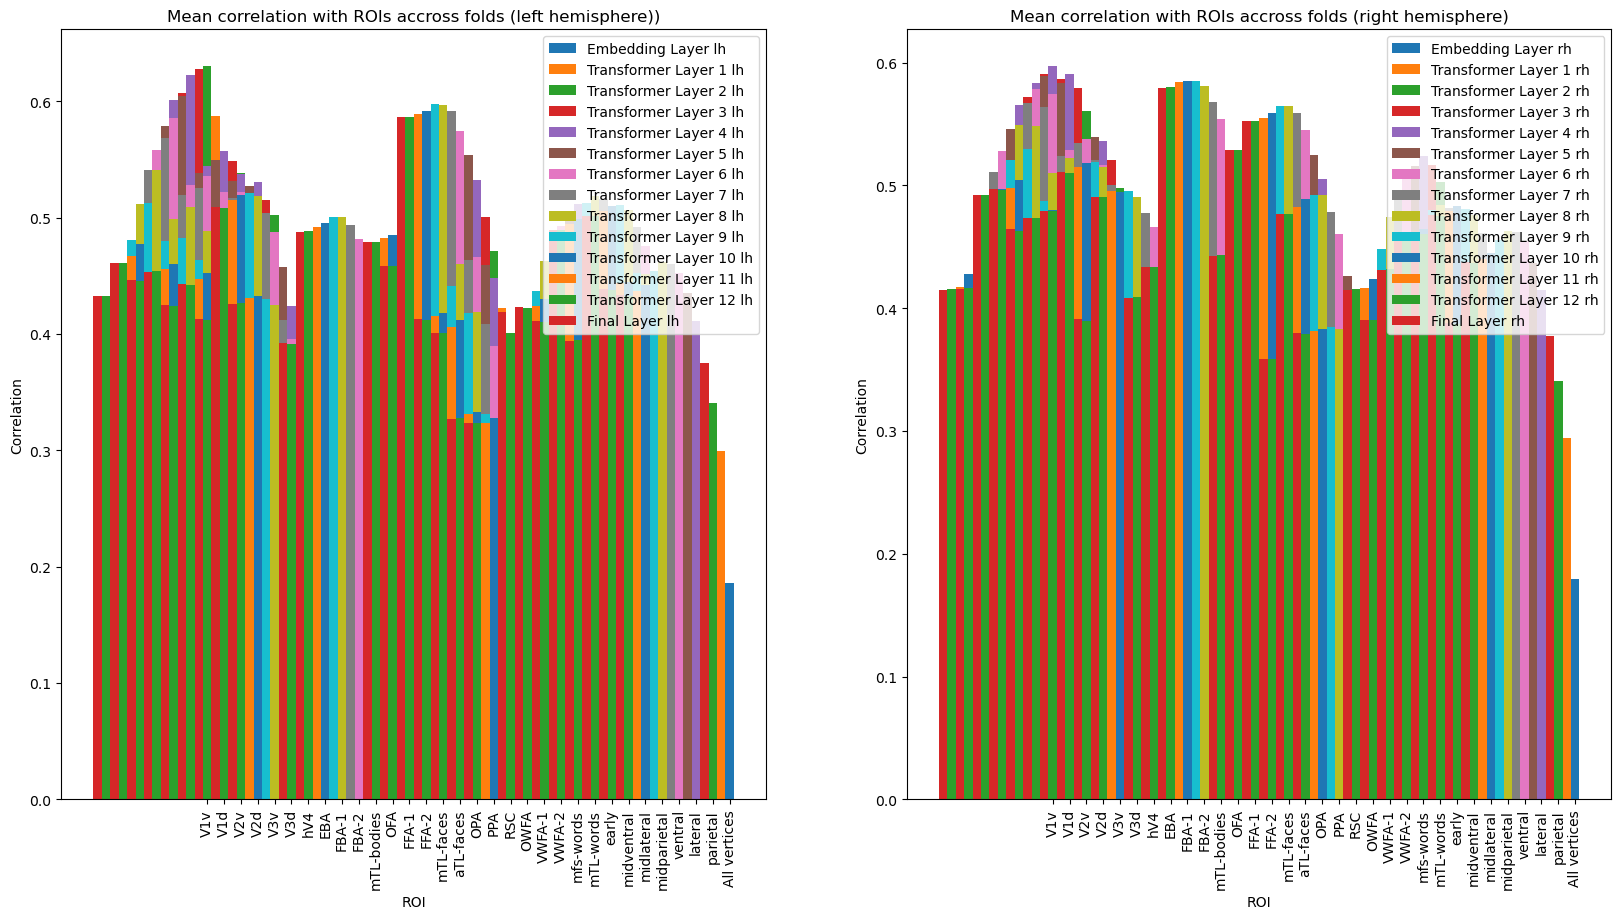

In [59]:
kfold.plot_results()

Index(['layer', 'correlation'], dtype='object')

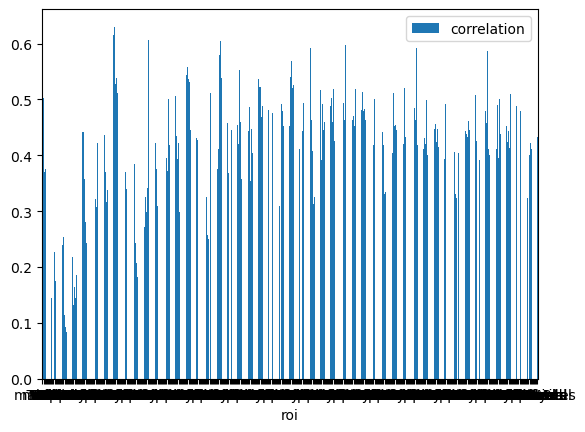

In [92]:
# use df to plot
# Make two side by side plots for left and right hemisphere
# Plot ROIs on x-axis and correlations on y-axis for each model
# Make sure, bars are in the same order for both plots
# Make sure, each bar has the same color in both plots
# Make sure, the bars are sorted by layer
# Make sure, each layer has their own color with no overlap
# Plot a legend below the plots
folder = "validations/validation001/results.csv"
df = pd.read_csv(folder)
# drop model column
df = df.drop("model", axis=1)
# set roi names as index
df = df.set_index("roi")

# select only left hemisphere
df_lh = df[df["hemisphere"] == "lh"]
df_rh = df[df["hemisphere"] == "rh"]
# drop hemisphere column
df_lh = df_lh.drop("hemisphere", axis=1)
df_rh = df_rh.drop("hemisphere", axis=1)


# bar plot with layer as group and roi as x-axis
df_lh.plot.bar(rot=0)






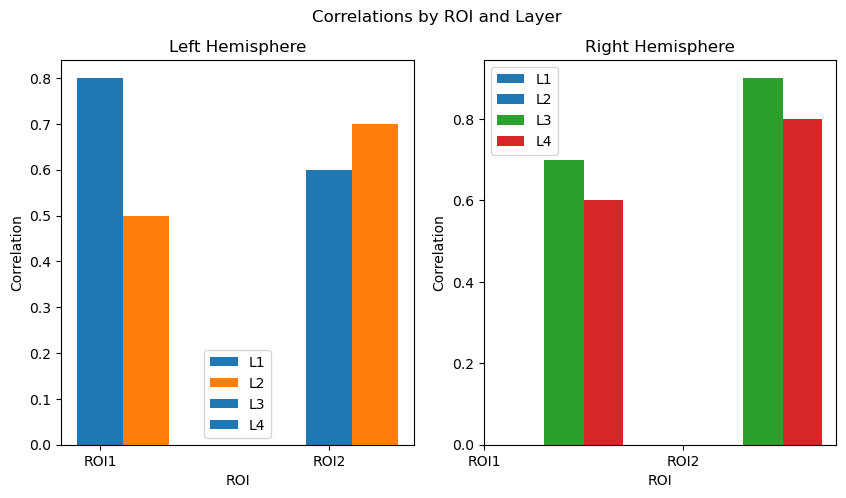

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example data
data = {'layer': ['L1', 'L1', 'L2', 'L2', 'L3', 'L3', 'L4', 'L4'],
        'roi': ['ROI1', 'ROI2', 'ROI1', 'ROI2', 'ROI1', 'ROI2', 'ROI1', 'ROI2'],
        'hemisphere': ['Left', 'Left', 'Left', 'Left', 'Right', 'Right', 'Right', 'Right'],
        'correlation': [0.8, 0.6, 0.5, 0.7, 0.7, 0.9, 0.6, 0.8]}

df = pd.DataFrame(data)

# Split data into left and right hemispheres
left_df = df[df['hemisphere'] == 'Left']
right_df = df[df['hemisphere'] == 'Right']

# Create bar plots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Correlations by ROI and Layer')

# Plot left hemisphere data
for i, layer in enumerate(['L1', 'L2', 'L3', 'L4']):
    layer_data = left_df[left_df['layer'] == layer]
    x = np.arange(len(layer_data['roi']))
    axes[0].bar(x + i * 0.2, layer_data['correlation'], width=0.2, label=layer)

axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['ROI1', 'ROI2'])
axes[0].set_title('Left Hemisphere')
axes[0].set_xlabel('ROI')
axes[0].set_ylabel('Correlation')
axes[0].legend()

# Plot right hemisphere data
for i, layer in enumerate(['L1', 'L2', 'L3', 'L4']):
    layer_data = right_df[right_df['layer'] == layer]
    x = np.arange(len(layer_data['roi']))
    axes[1].bar(x + i * 0.2, layer_data['correlation'], width=0.2, label=layer)

axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['ROI1', 'ROI2'])
axes[1].set_title('Right Hemisphere')
axes[1].set_xlabel('ROI')
axes[1].set_ylabel('Correlation')
axes[1].legend()

plt.show()


C:\Users\luke-\AppData\Local\Temp\ipykernel_12384\1449448367.py:50: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  row_colors = [layer_colors[layer] for layer in left_df.groupby('layer').mean().sort_values(by='correlation', ascending=False).index]
C:\Users\luke-\AppData\Local\Temp\ipykernel_12384\1449448367.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  axes[0].table(cellText=left_df.groupby('layer').mean().sort_values(by='correlation', ascending=False).round(3).values, rowLabels=df.groupby('layer').mean().sort_values(by='correlation', ascending=False).index, colLabels=["Mean Correlation"], rowColours=

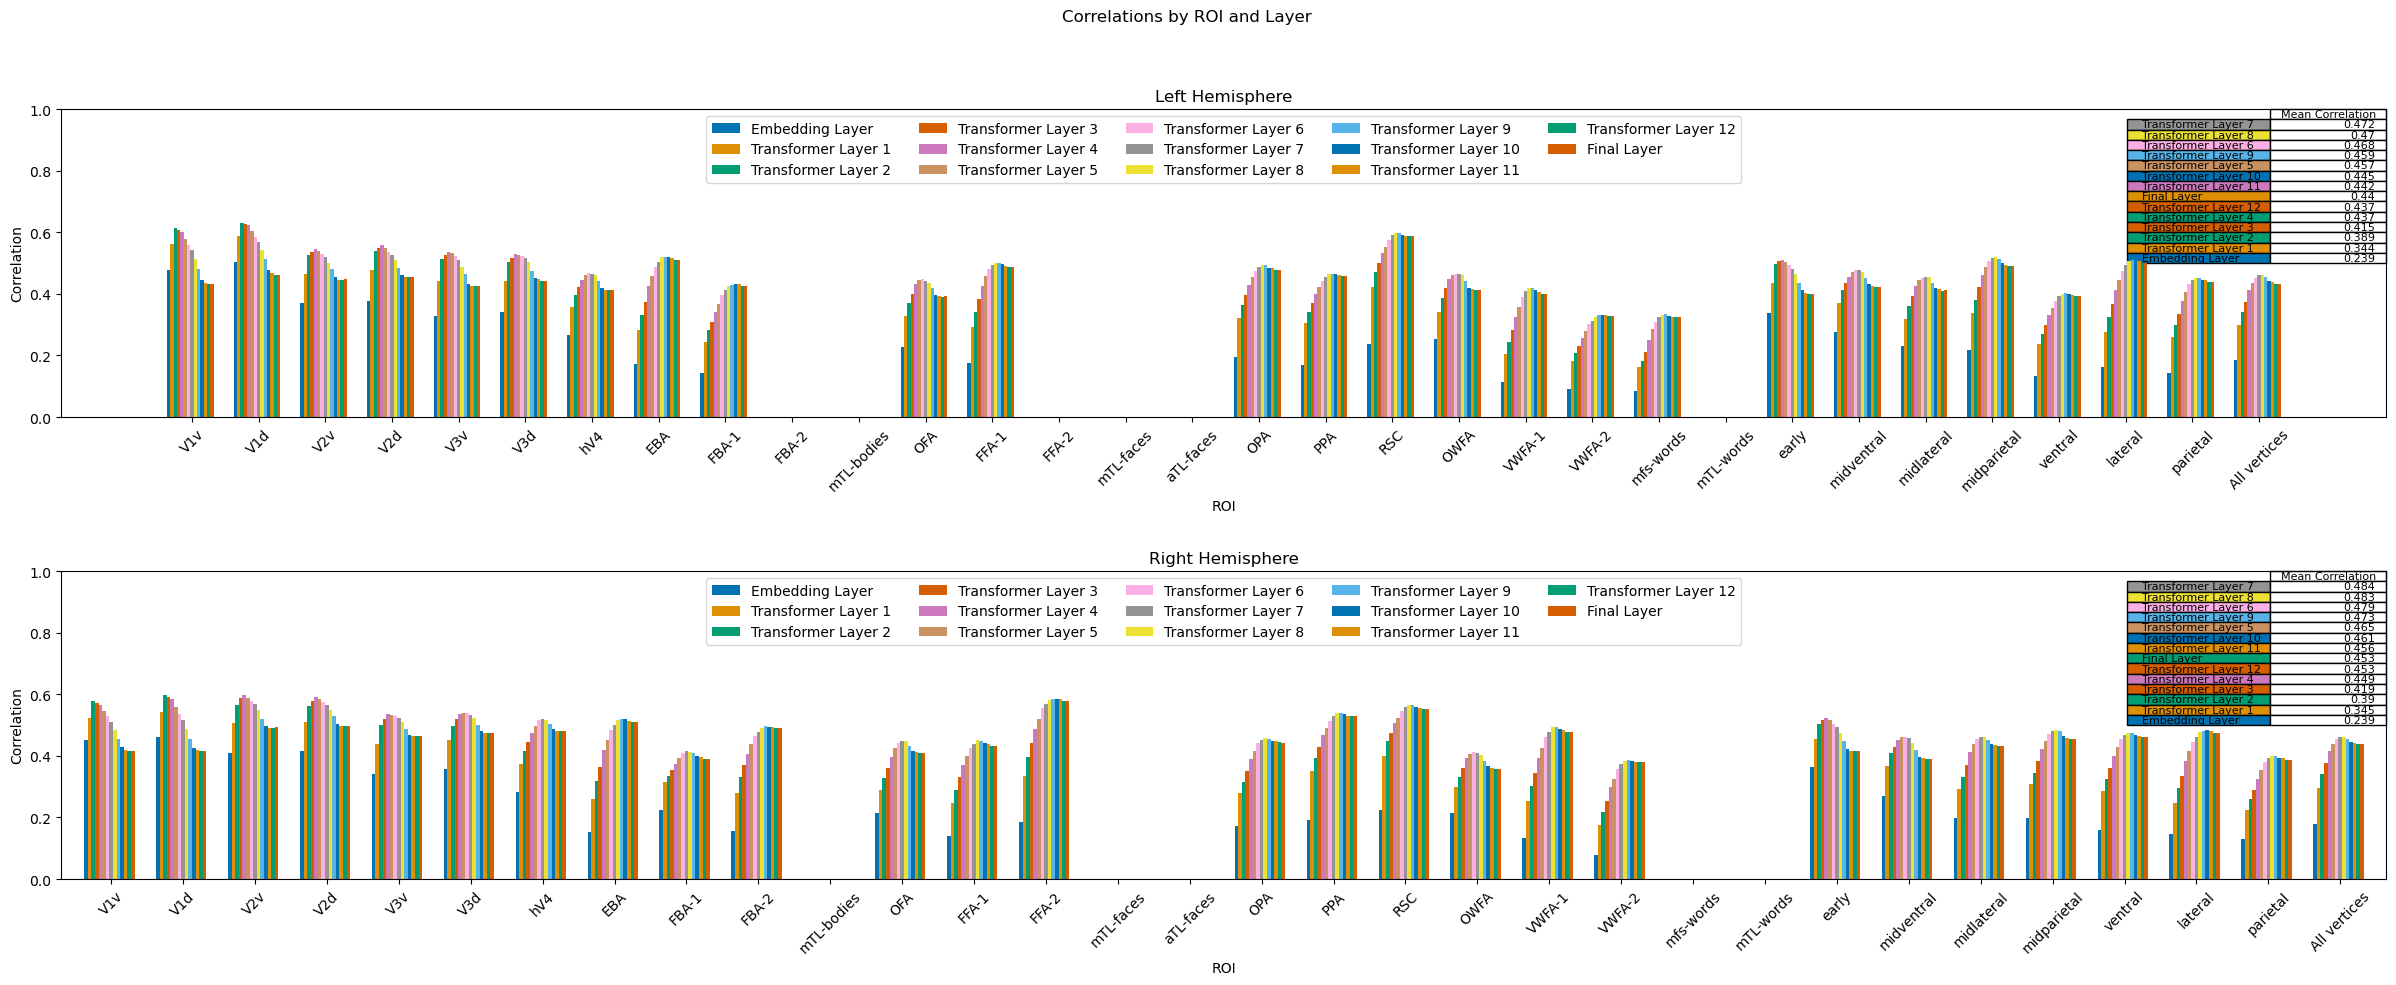

C:\Users\luke-\AppData\Local\Temp\ipykernel_12384\1449448367.py:73: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('layer').mean().sort_values(by='correlation', ascending=False)


,correlation
layer,
Transformer Layer 7,0.478055
Transformer Layer 8,0.476244
Transformer Layer 6,0.473575
Transformer Layer 9,0.466281
Transformer Layer 5,0.461044
Transformer Layer 10,0.453157
Transformer Layer 11,0.448530
Final Layer,0.445563
Transformer Layer 12,0.445485


In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example data
data = {'layer': ['L1', 'L1', 'L2', 'L2', 'L3', 'L3', 'L4', 'L4'],
        'roi': ['ROI1', 'ROI2', 'ROI1', 'ROI2', 'ROI1', 'ROI2', 'ROI1', 'ROI2'],
        'hemisphere': ['Left', 'Left', 'Left', 'Left', 'Right', 'Right', 'Right', 'Right'],
        'correlation': [0.8, 0.6, 0.5, 0.7, 0.7, 0.9, 0.6, 0.8]}

df = pd.DataFrame(data)

folder = "validations/validation001/results.csv"
df = pd.read_csv(folder)
# drop model column
df = df.drop("model", axis=1)

# Define color palette and assign colors to layers
palette = sns.color_palette("colorblind", 14)
layer_colors = {layer: palette[i] for i, layer in enumerate(df.layer.unique())}

# Split data into left and right hemispheres
left_df = df[df['hemisphere'] == 'lh']
right_df = df[df['hemisphere'] == 'rh']

# Create bar plots
fig, axes = plt.subplots(2, 1, figsize=(30, 10))
fig.suptitle('Correlations by ROI and Layer')
plt.subplots_adjust(hspace=0.5)
# reduce white space before first x tick
plt.margins(x=0.01)

bar_width = 0.05
# Plot left hemisphere data
for i, layer in enumerate(df.layer.unique()):
    layer_data = left_df[left_df['layer'] == layer]
    x = np.arange(len(layer_data['roi']))
    # center bars around xtick
    axes[0].bar(x - len(df.layer.unique())/2 * 0.05 + i * 0.05, layer_data['correlation'], width=bar_width, label=layer, color=layer_colors[layer])

axes[0].set_xticks([i for i in range(len(layer_data['roi']))])
axes[0].set_xticklabels([roi for roi in layer_data['roi']])
axes[0].set_title('Left Hemisphere')
axes[0].set_xlabel('ROI')
axes[0].tick_params(axis='x', labelrotation=45)
axes[0].set_ylabel('Correlation')
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=5)
axes[0].set_ylim([0, 1])
row_colors = [layer_colors[layer] for layer in left_df.groupby('layer').mean().sort_values(by='correlation', ascending=False).index]
axes[0].table(cellText=left_df.groupby('layer').mean().sort_values(by='correlation', ascending=False).round(3).values, rowLabels=df.groupby('layer').mean().sort_values(by='correlation', ascending=False).index, colLabels=["Mean Correlation"], rowColours=row_colors, bbox = [0.95, 0.5, 0.05, 0.5])


# Plot right hemisphere data
for i, layer in enumerate(df.layer.unique()):
    layer_data = right_df[right_df['layer'] == layer]
    x = np.arange(len(layer_data['roi']))
    axes[1].bar(x - len(df.layer.unique())/2 * 0.05 + i * 0.05, layer_data['correlation'], width=bar_width, label=layer, color=layer_colors[layer])

axes[1].set_xticks([i for i in range(len(layer_data['roi']))])
axes[1].set_xticklabels([roi for roi in layer_data['roi']])
axes[1].set_title('Right Hemisphere')
axes[1].set_xlabel('ROI')
axes[1].tick_params(axis='x', labelrotation=45)
axes[1].set_ylabel('Correlation')
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=5)
axes[1].set_ylim([0, 1])
row_colors = [layer_colors[layer] for layer in right_df.groupby('layer').mean().sort_values(by='correlation', ascending=False).index]
axes[1].table(cellText=right_df.groupby('layer').mean().sort_values(by='correlation', ascending=False).round(3).values, rowLabels=df.groupby('layer').mean().sort_values(by='correlation', ascending=False).index, colLabels=["Mean Correlation"], rowColours=row_colors, bbox = [0.95, 0.5, 0.05, 0.5])


plt.show()
df.groupby('layer').mean().sort_values(by='correlation', ascending=False)

## Create Submission

In [166]:
subjects = [Subject(f"subj0{i}") for i in range(1, 9)]
CreateSubmission(subjects=subjects, procedure=CLIPVisionLayer7PCA200LinearRegression()).run()

Training images: 9841
Test images: 159
Training captions: 9841
Test captions: 159
Train image dataloader: 33 batches
Test image dataloader: 1 batches
Train caption dataloader: 33 batches
Test caption dataloader: 1 batches
Left hemisphere neural data loaded. Shape: (9841, 19004)
Right hemisphere neural data loaded. Shape: (9841, 20544)


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Training images: 9841
Test images: 159
Training captions: 9841
Test captions: 159
Train image dataloader: 33 batches
Test image dataloader: 1 batches
Train caption dataloader: 33 batches
Test caption dataloader: 1 batches
Left hemisphere neural data loaded. Shape: (9841, 19004)
Right hemisphere neural data loaded. Shape: (9841, 20544)


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


Training images: 9082
Test images: 293
Training captions: 9082
Test captions: 918
Train image dataloader: 31 batches
Test image dataloader: 1 batches
Train caption dataloader: 31 batches
Test caption dataloader: 4 batches
Left hemisphere neural data loaded. Shape: (9082, 19004)
Right hemisphere neural data loaded. Shape: (9082, 20544)


100%|██████████| 1/1 [00:04<00:00,  4.81s/it]


Training images: 8779
Test images: 395
Training captions: 8779
Test captions: 1221
Train image dataloader: 30 batches
Test image dataloader: 2 batches
Train caption dataloader: 30 batches
Test caption dataloader: 5 batches
Left hemisphere neural data loaded. Shape: (8779, 19004)
Right hemisphere neural data loaded. Shape: (8779, 20544)


100%|██████████| 2/2 [00:06<00:00,  3.25s/it]


Training images: 9841
Test images: 159
Training captions: 9841
Test captions: 159
Train image dataloader: 33 batches
Test image dataloader: 1 batches
Train caption dataloader: 33 batches
Test caption dataloader: 1 batches
Left hemisphere neural data loaded. Shape: (9841, 19004)
Right hemisphere neural data loaded. Shape: (9841, 20544)


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


Training images: 9082
Test images: 293
Training captions: 9082
Test captions: 918
Train image dataloader: 31 batches
Test image dataloader: 1 batches
Train caption dataloader: 31 batches
Test caption dataloader: 4 batches
Left hemisphere neural data loaded. Shape: (9082, 18978)
Right hemisphere neural data loaded. Shape: (9082, 20220)


100%|██████████| 1/1 [00:04<00:00,  4.74s/it]


Training images: 9841
Test images: 159
Training captions: 9841
Test captions: 159
Train image dataloader: 33 batches
Test image dataloader: 1 batches
Train caption dataloader: 33 batches
Test caption dataloader: 1 batches
Left hemisphere neural data loaded. Shape: (9841, 19004)
Right hemisphere neural data loaded. Shape: (9841, 20544)


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


Training images: 8779
Test images: 395
Training captions: 8779
Test captions: 1221
Train image dataloader: 30 batches
Test image dataloader: 2 batches
Train caption dataloader: 30 batches
Test caption dataloader: 5 batches
Left hemisphere neural data loaded. Shape: (8779, 18981)
Right hemisphere neural data loaded. Shape: (8779, 20530)


100%|██████████| 2/2 [00:06<00:00,  3.29s/it]
